In [1]:
import numpy as np
import data_gen1 as dg
import matplotlib.pylab as plt
import random

random.seed(22)

In [2]:
points, labels = dg.gen(n=8) # generates 8 clusters
x_p = [ points[i][0] for i in range(len(points)) ]
y_p = [ points[i][1] for i in range(len(points)) ]
x_id = np.linspace(0,20)
y_id = np.linspace(0,20)

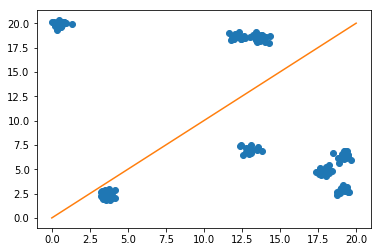

In [3]:
plt.plot(x_p,y_p,'o',x_id,y_id,'-')
plt.show()

By choosing a variable, we essentially project all the points onto a straight line. If we project all the points
onto the line $y = 0$, we get the following graph. Note that we are ignoring the label for now.

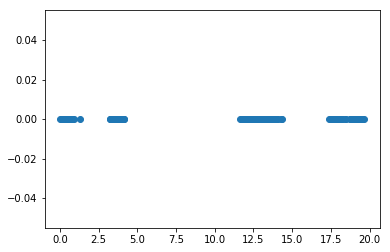

In [4]:
plt.plot(x_p, [0 for i in range(len(points))], 'o')
plt.show()

By using the label, we can further differentiate the clusters. The below graph again shows a projection of the
points onto the x-axis, but those with label 1 have been projected to the line $y=1$ for visual purposes.

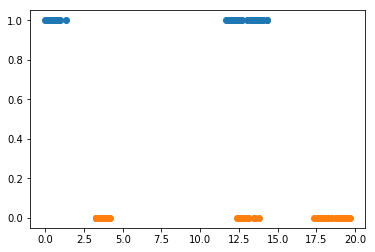

In [5]:
x1 = []
x2 = []
for i in range(len(points)):
    p = points[i]
    l = labels[i]
    if l == 0:
        x1.append(p[0])
    else:
        x2.append(p[0])
plt.plot(x1, [1 for i in range(len(x1))], 'o', x2, [0 for i in range(len(x2))], 'o')
plt.show()

We can see that in the first graph, some of the clusters have merged, which are differentiated in the second graph.
We still are not differentiate every cluster because in this case, both one dimension is as important as the
other (data is generated randomly and the line $x=y$ should roughly split it in half). Even so, we can see that adding
a dimension leads to information gain. This is what we want to exploit with a decision tree.

So how can we find a decision boundary for these clusters? If one were to draw boundaries for the graph above, one
possible way could be:

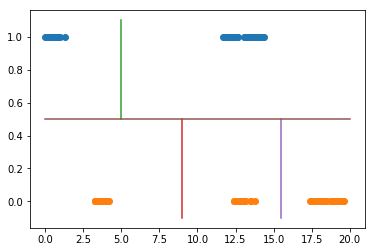

In [6]:
y_l1 = np.linspace(0.5,1.1)
x_l1 = [5 for i in range(len(y_l1))]
x_l2 = [12.8 for i in range(len(y_l1))]

y_l2 = np.linspace(-0.1,0.5)
x_l3 = [9 for i in range(len(y_l1))]
x_l4 = [15.5 for i in range(len(y_l1))]

x = np.linspace(0,20)

plt.plot(x1, [1 for i in range(len(x1))], 'o', x2, [0 for i in range(len(x2))], 'o', 
         x_l1,y_l1,
         x_l3,y_l2,x_l4,y_l2,
         x,[0.5 for i in range(len(x))])
plt.show()

To have the highest confidence that a point belows in the specified cluster, we need
to: a) minimize the distance to its centroid; b) maximize the distance from the boundary.
With the second condition, we are trying to avoid arbitrarily splitting a cluster.

We say a point $p$ belongs in cluster $c$ wrt to boundary $b$ if the distance 
to the nearest point in $c$ to $p$ is less than the distance to $b$. Then, a good boundary
is one that creates classifies as many points into clusters, while minimizing number of points
that does not belong in clusters. Additionally, we also want to pick a boundary such that
the distances between points and their respective centroid is minimize.
We can use entropy to quantify this:

In [7]:
def log2(p):
    if (p==0):
        return 0
    else:
        return np.log2(p)

def avg(d):
    if (len(d)==0):
        return 0
    return sum(d)/len(d)

# not general algorithm, only working with (label, x)
def construct_tree(data, b):
    # split the data into left/right of boundary
    d1 = []
    d2 = []
    n = len(data)
    # iterate through x = [0,20]
    x_b = np.linspace(0,20)
    best_x = 0
    min_ent = 1
    best_dist = 400
    
    ents = []
    dists = []
    
    for x in x_b:
        d1 = []
        d2 = []
        n_clustered = 0
        
        # partition
        for d in data:
            if d <= x:
                d1.append(d)
            else:
                d2.append(d)
        
        # compute centroid for each partition
        c1 = avg(d1)
        c2 = avg(d2)
        
        # compute average distance to centroid
        dist_to_c1 = 0
        dist_to_c2 = 0
        for d in d1:
            dist_to_c1 += (d-c1)**2/len(d1)
        for d in d2:
            dist_to_c2 += (d-c2)**2/len(d2)
        
        # compare square distances between points and boundary
        # left partition
        for d in d1:
            dist = []
            for dd in d1:
                if dd != d:
                    dist.append((dd-d)**2)
            if len(dist) != 0:
                dist_p = min(dist)
                dist_b = (d-x)**2
                if dist_b < dist_p:
                    n_clustered += 1
        # right partition
        for d in d2:
            dist = []
            for dd in d2:
                if dd != d:
                    dist.append((dd-d)**2)
            if len(dist) != 0:
                dist_p = min(dist)
                dist_b = (d-x)**2
                if dist_b < dist_p:
                    n_clustered += 1
        
        # compute entropy for this boundary
        p1 = n_clustered/n
        p2 = 1-p1
        entropy = -p1*log2(p1) - p2*log2(p2)
        ents.append(entropy)
        dists.append((dist_to_c1+dist_to_c2)/2)
        if entropy <= min_ent and (dist_to_c1+dist_to_c2)/2 < best_dist:
            min_ent = entropy
            best_x = x
            best_dist = (dist_to_c1+dist_to_c2)/2
    b.append(best_x)
    
    dists = [dists[i]/37 for i in range(len(dists))]
    plt.plot(x_b, ents, 'r', x_b, dists, 'b')
    

Again, as a reminder, here are the points whose label is $1$:

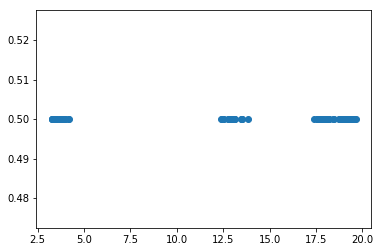

In [8]:
px = []
for i in range(len(points)):
    if (labels[i] == 1):
        px.append(points[i][0])
plt.plot(px,[0.5 for i in range(len(px))],'o')
plt.show()

Finally, let's run the algorithm in just one level and graph the entropy (red) and average distance to centroids (blue) for
different values $x_i$ such that the boundary is $x = x_i$

In [9]:
b = []
construct_tree(px,b)

Now, if we super-impose the points onto the above graph, then we can see how distance and entropy change
as we change the boundaries:

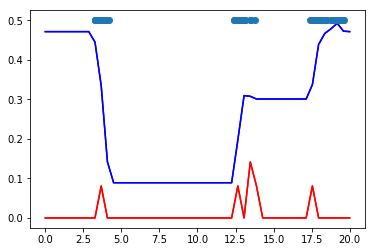

In [10]:
construct_tree(px,b)
plt.plot(px,[0.5 for i in range(len(px))],'o')
plt.show()

There are several interesting things happening above. Firstly, when a boundary cuts through a cluster,
we can see a spike in entropy. This is more strongly pronounced in the first two clusters than the last.
This is probably because a larger cluster is more likely to be spread further apart (in this case, it's
a mixture of three Gaussian distributions); thus, it is preferable to split a larger, looser cluster than
a smaller, tighter one. Secondly, there are many boundaries that result in entropy of zero: before and after
the points, as well as in between the clusters. However, the average distance is further if we split between
second and third clusters than if we split between the first two. This is because the last two clusters
are more alike compared to the first. Next graph shows the boundary the algorithm chose:

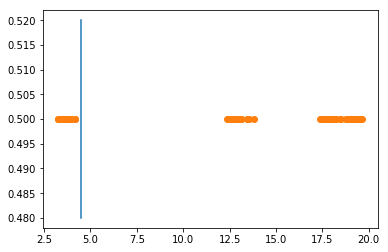

In [11]:
ys = np.linspace(0.48,0.52)
plt.plot([b[0] for i in range(len(ys))],ys,'-',px,[0.5 for i in range(len(px))],'o')
plt.show()

Next, we modify the algorithm to be recursive, stopping when the split leads to one side being zero:

In [12]:
def construct_tree_rec(data, b):
    n = len(data)
    # iterate through x = [0,20]
    x_b = np.linspace(0,20)
    best_x = 0
    min_ent = 1
    best_dist = 400
    
    ents = []
    dists = []
    
    for x in x_b:
        d1 = []
        d2 = []
        n_clustered = 0
        
        # partition
        for d in data:
            if d <= x:
                d1.append(d)
            else:
                d2.append(d)
        
        # compute centroid for each partition
        c1 = avg(d1)
        c2 = avg(d2)
        
        # compute average distance to centroid
        dist_to_c1 = 0
        dist_to_c2 = 0
        for d in d1:
            dist_to_c1 += (d-c1)**2/len(d1)
        for d in d2:
            dist_to_c2 += (d-c2)**2/len(d2)
        
        # compare square distances between points and boundary
        # left partition
        for d in d1:
            dist = []
            for dd in d1:
                if dd != d:
                    dist.append((dd-d)**2)
            if len(dist) != 0:
                dist_p = min(dist)
                dist_b = (d-x)**2
                if dist_b < dist_p:
                    n_clustered += 1
        # right partition
        for d in d2:
            dist = []
            for dd in d2:
                if dd != d:
                    dist.append((dd-d)**2)
            if len(dist) != 0:
                dist_p = min(dist)
                dist_b = (d-x)**2
                if dist_b < dist_p:
                    n_clustered += 1
        
        # compute entropy for this boundary
        p1 = n_clustered/n
        p2 = 1-p1
        entropy = -p1*log2(p1) - p2*log2(p2)
        ents.append(entropy)
        dists.append((dist_to_c1+dist_to_c2)/2)
        if entropy <= min_ent and (dist_to_c1+dist_to_c2)/2 < best_dist:
            min_ent = entropy
            best_x = x
            best_dist = (dist_to_c1+dist_to_c2)/2
    d1 = []
    d2 = []
    for d in data:
        if d < best_x:
            d1.append(d)
        else:
            d2.append(d)
    if len(d1) == 0 or len(d2) == 0:
        return
    b.append(best_x)
    
    construct_tree_rec(d1, b)
    construct_tree_rec(d2, b)

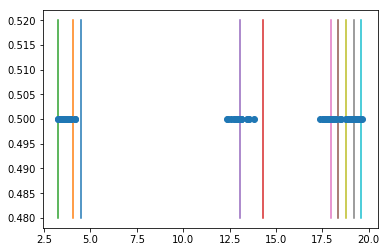

In [13]:
b = []
ys = np.linspace(0.48,0.52)
construct_tree_rec(px,b)
for split_val in b:
    plt.plot([split_val for i in range(len(ys))], ys,'-')
plt.plot(px,[0.5 for i in range(len(px))],'o')
plt.show()

Finally, let's superimpose the boundaries we found onto the original points:

b: [4.4897959183673475, 4.0816326530612246, 3.2653061224489797, 14.285714285714286, 13.061224489795919, 18.367346938775512, 17.95918367346939, 19.183673469387756, 18.775510204081634, 19.591836734693878]


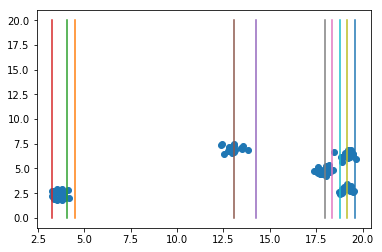

In [14]:
# find points with label = 1
px = []
py = []
for i in range(len(points)):
    if labels[i] == 1:
        px.append(points[i][0])
        py.append(points[i][1])
ys = np.linspace(0,20)
plt.plot(px,py,'o')
for split_val in b:
    plt.plot([split_val for i in range(len(ys))], ys,'-')
print("b:",b)
plt.show()

The last group of clusters are not easily separable (indeed, one could even classifier that whole group as a single cluster),
so the boundary that it finds does not exactly separating things. 
Furthermore, we're a little too zealous on splitting the data. This is
the usual problem with fully grown decision trees (prone to overfit). Let's look at a pruned tree:

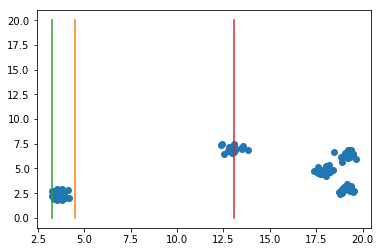

In [15]:
plt.plot(px,py,'o',
         [b[0] for i in range(len(ys))],ys,'-',
         
         [b[2] for i in range(len(ys))],ys,'-',
         
         [b[4] for i in range(len(ys))],ys,'-',
         
        )
plt.show()

At this point, there are some obvious things to try to modify and tune. First, we could try to change our 
definition of what it means to belong in a cluster similar to KNN. That is, a point $p$ belongs in cluster $c$
wrt to boundary $b$ if the majority of its $k$ nearest neighbours below to $c$. Otherwise, we again say $p$ is
unclassified wrt to $b$. Second, we have two metrics to measure how good a boundary is: average distance to
the centroids and entropy. Currently, we first minimize entropy then centroid, but we could use a weight average
between the two instead. This weight would then become a hyperparameter to tune.

We conclude this by doing a full example on another set of points:

In [16]:
points, labels = dg.gen(n=8,n_gen=25)

# training samples
x_train = []
y_train = []
l_train = []

# testing sample
x_test = []
y_test = []
l_test = []

for i in range(8):
    x_train += [points[i*25+j][0] for j in range(20)]
    y_train += [points[i*25+j][1] for j in range(20)]
    l_train += [labels[i*25+j] for j in range(20)]
    
    x_test += [points[i*25+j][0] for j in range(20,25)]
    y_test += [points[i*25+j][1] for j in range(20,25)]
    l_test += [labels[i*25+j] for j in range(20,25)]

This is the training data:

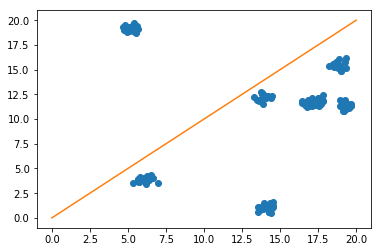

In [17]:
x_id = np.linspace(0,20)
y_id = np.linspace(0,20)
plt.plot(x_train,y_train,'o',x_id,y_id,'-')
plt.show()

Here is the test (validation) data $(l,x)$

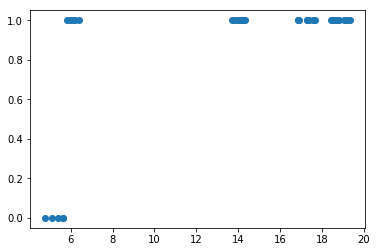

In [18]:
plt.plot(x_test,l_test,'o')
plt.show()

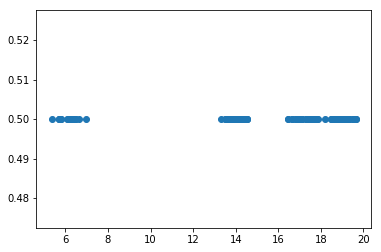

In [19]:
px = []
py = []
for i in range(len(x_train)):
    if l_train[i] == 1:
        px.append(x_train[i])
        py.append(y_train[i])
plt.plot(px,[0.5 for i in range(len(px))],'o')
plt.show()

In [20]:
b = []
construct_tree_rec(px,b)
b.append(0)
b.append(20)
b.sort()
print("b:",b)

b: [0, 6.5306122448979593, 6.9387755102040813, 7.3469387755102042, 14.693877551020408, 16.73469387755102, 17.551020408163264, 19.591836734693878, 20]


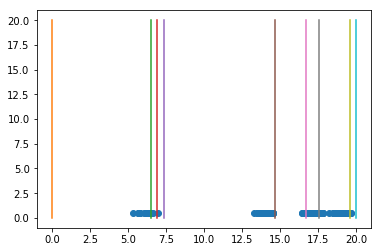

In [21]:
ys = np.linspace(0,20)
plt.plot(px,[0.5 for i in range(len(px))],'o')
for split_val in b:
    plt.plot([split_val for i in range(len(ys))], ys,'-')
plt.show()

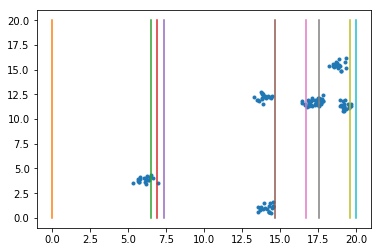

In [22]:
plt.plot(px,py,'.')
for split_val in b:
    plt.plot([split_val for i in range(len(ys))], ys,'-')
plt.show()

In [23]:
centroid = []
for i in range(len(b)-1):
    n_pts = 0
    x_total = 0
    y_total = 0
    for j in range(len(px)):
        if px[j] > b[i] and px[j] <= b[i+1]:
            n_pts += 1
            x_total += px[j]
            y_total += py[j]
    if n_pts != 0:
        centroid.append((x_total/n_pts, y_total/n_pts))

Here are the centroids that the algorithm found:

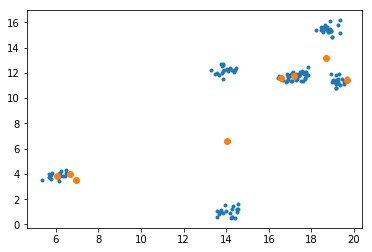

In [24]:
xs = [centroid[i][0] for i in range(len(centroid))]
ys = [centroid[i][1] for i in range(len(centroid))]
plt.plot(px,py,'.',xs,ys,'o')
plt.show()

Finally, here are the centroids compared to the test data:

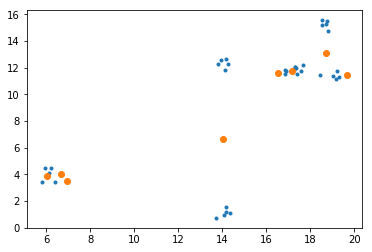

In [25]:
px = []
py = []
for i in range(len(x_test)):
    if l_test[i] == 1:
        px.append(x_test[i])
        py.append(y_test[i])

xs = [centroid[i][0] for i in range(len(centroid))]
ys = [centroid[i][1] for i in range(len(centroid))]
plt.plot(px,py,'.',xs,ys,'o')
plt.show()